In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.simplefilter('ignore')

from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

from mlxtend.classifier import StackingCVClassifier
import shap

Changelog:
- v1 - base submission
- v2 - l1 models - cb, lgbm, rf, extree
- v3/4 - model understanding (Shap), l1 models hyperparameters tuning
- v8 (2021-04-30) - many improvements - best l1 model combination, meta-model hyperparameter search

## If you like it (use it - code or submission file) - **please vote**. This is my first notebook published on Kaggle. I really appreciate any feedback and next improvements, suggestions.

Many thanks to Kaggle Masters:
- [BIZEN (hiro5299834](https://www.kaggle.com/hiro5299834) - [TPS Apr 2021 pseudo labeling/voting ensemble](https://www.kaggle.com/hiro5299834/tps-apr-2021-pseudo-labeling-voting-ensemble?scriptVersionId=60616606)  
- [Alexander Ryzhkov](https://www.kaggle.com/alexryzhkov) - [LightAutoML interpretable model - AutoWoE](https://www.kaggle.com/alexryzhkov/lightautoml-interpretable-model-autowoe?scriptVersionId=60651790)
- [Jeong-Yoon Lee](https://www.kaggle.com/hiro5299834) - [AutoEncoder + Pseudo Label + AutoLGB](https://www.kaggle.com/jeongyoonlee/autoencoder-pseudo-label-autolgb)

# 1. Description

This is a very simple example of how to quickly prepare a preliminary analysis of classification models using the ensemble-learning meta-classifier for stacking using cross-validation. 

As described originally in [MLExtend](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/)

> Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The StackingCVClassifier extends the standard stacking algorithm (implemented as StackingClassifier) using cross-validation to prepare the input data for the level-2 classifier.

> In the standard stacking procedure, the first-level classifiers are fit to the same training set that is used prepare the inputs for the second-level classifier, which may lead to overfitting. The StackingCVClassifier, however, uses the concept of cross-validation: the dataset is split into k folds, and in k successive rounds, k-1 folds are used to fit the first level classifier; in each round, the first-level classifiers are then applied to the remaining 1 subset that was not used for model fitting in each iteration. The resulting predictions are then stacked and provided -- as input data -- to the second-level classifier. After the training of the StackingCVClassifier, the first-level classifiers are fit to the entire dataset as illustrated in the figure below.

![](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier_files/stacking_cv_classification_overview.png)

# 2. Set up script parameters

In [2]:
RANDOM_SEED = 2021
PROBAS = True
FOLDS = 5
N_ESTIMATORS = 1000

TARGET = 'Survived'

# 3. Load TPS-04 competition data

In [3]:
train = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')

# Pseudo labels taken from great BIZEN notebook: https://www.kaggle.com/hiro5299834/tps-apr-2021-pseudo-labeling-voting-ensemble
pseudo_labels = pd.read_csv("../input/sub-top/sub_top.csv")
test[TARGET] = pseudo_labels[TARGET]

# 4. Preprocess data
I use the way of processing data from [BIZEN](https://www.kaggle.com/hiro5299834/tps-apr-2021-pseudo-labeling-voting-ensemble) notebook (as a benchmark) to compare results.

## 4A. Filling missing data

In [4]:
train['FirstName'] = train['Name'].apply(lambda x:x.split(', ')[0])
train['n'] = 1
gb = train.groupby('FirstName')
df_names = gb['n'].sum()
train['SameFirstName'] = train['FirstName'].apply(lambda x:df_names[x])

test['FirstName'] = test['Name'].apply(lambda x:x.split(', ')[0])
test['n'] = 1
gb = test.groupby('FirstName')
df_names = gb['n'].sum()
test['SameFirstName'] = test['FirstName'].apply(lambda x:df_names[x])


all_df = pd.concat([train, test], axis=0)

all_df['AnyMissing'] = np.where(all_df.isnull().any(axis=1) == True, 1, 0)


all_df['FamilySize'] = all_df['SibSp'] + all_df['Parch'] + 1
all_df['IsAlone'] = np.where(all_df['FamilySize'] <= 1, 1, 0)


all_df['Has_Cabin'] = all_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
all_df['Cabin'] = all_df['Cabin'].fillna('X').map(lambda x: x[0].strip())
cabin_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5,
             'F': 6, 'G': 7, 'T': 1, 'X': 8}
all_df['Cabin'] = all_df['Cabin'].str[0].fillna('X').replace(cabin_map)

all_df['Embarked'] = all_df['Embarked'].fillna("No")
conditions = [
    (all_df['Embarked']=="S"),
    (all_df['Embarked']=="Q"),
    (all_df['Embarked']=="C"),
    (all_df['Embarked']=="No")
]
choices = [0, 1, 2, -1]
all_df["Embarked"] = np.select(conditions, choices)
all_df['Embarked'] = all_df['Embarked'].astype(int)


all_df['SecondName'] = all_df.Name.str.split(', ', 1, expand=True)[1] # to try
all_df['IsFirstNameDublicated'] = np.where(all_df.FirstName.duplicated(), 1, 0)


all_df['Fare'] = all_df['Fare'].fillna(train['Fare'].median())

conditions = [
    (all_df['Fare'] <= 7.91),
    ((all_df['Fare'] > 7.91) & (all_df['Fare'] <= 14.454)),
    ((all_df['Fare'] > 14.454) & (all_df['Fare'] <= 31)),
    (all_df['Fare'] > 31)
]

choices = [0, 1, 2, 3]
all_df["Fare"] = np.select(conditions, choices)
all_df['Fare'] = all_df['Fare'].astype(int)


all_df['Ticket'] = all_df.Ticket.str.replace('\.','', regex=True).\
                    str.replace('(\d+)', '', regex=True).\
                    str.replace(' ', '', regex=True).\
                    replace(r'^\s*$', 'X', regex=True).\
                    fillna('X')

 
conditions = [
    ((all_df.Sex=="female")&(all_df.Pclass==1)&(all_df.Age.isnull())),
    ((all_df.Sex=="male")&(all_df.Pclass==1)&(all_df.Age.isnull())),
    ((all_df.Sex=="female")&(all_df.Pclass==2)&(all_df.Age.isnull())),
    ((all_df.Sex=="male")&(all_df.Pclass==2)&(all_df.Age.isnull())),
    ((all_df.Sex=="female")&(all_df.Pclass==3)&(all_df.Age.isnull())),
    ((all_df.Sex=="male")&(all_df.Pclass==3)&(all_df.Age.isnull()))]


choices = all_df[['Age', 'Pclass', 'Sex']].\
            dropna().\
            groupby(['Pclass', 'Sex']).\
            mean()['Age']

all_df["Age"] = np.select(conditions, choices)

conditions = [
    (all_df['Age'].le(16)),
    (all_df['Age'].gt(16) & all_df['Age'].le(32)),
    (all_df['Age'].gt(32) & all_df['Age'].le(48)),
    (all_df['Age'].gt(48) & all_df['Age'].le(64)),
    (all_df['Age'].gt(64))
]
choices = [0, 1, 2, 3, 4]

all_df["Age"] = np.select(conditions, choices)
all_df['Sex'] = np.where(all_df['Sex']=='male', 1, 0)
all_df = all_df.drop(['Name', 'n'], axis = 1)

In [5]:
all_df.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstName,SameFirstName,AnyMissing,FamilySize,IsAlone,Has_Cabin,SecondName,IsFirstNameDublicated
0,0,1,1,1,2,2,0,X,2,3,0,Oconnor,28,1,3,0,1,Frankie,0
1,1,0,3,1,1,0,0,X,1,8,0,Bryan,25,1,1,1,0,Drew,0
2,2,0,3,1,0,1,2,CA,3,8,0,Owens,79,1,4,0,0,Kenneth,0
3,3,0,3,1,0,0,0,A,1,8,0,Kramer,29,1,1,1,0,James,0
4,4,1,3,1,0,0,0,X,0,8,0,Bond,16,1,1,1,0,Michael,0


## 4B. Encoding data

In [6]:
label_cols = ['Ticket']

def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

scaler = StandardScaler()
all_df.Ticket = all_df[['Ticket']].apply(label_encoder)

features_selected = ['Pclass', 'Sex', 'Age','Embarked','Parch','SibSp','Fare','Cabin','Ticket','SameFirstName', 'Survived']
all_df = all_df[features_selected]

In [7]:
# First train data rows ... to look into ...

all_df.head(5)

,Pclass,Sex,Age,Embarked,Parch,SibSp,Fare,Cabin,Ticket,SameFirstName,Survived
0,1,1,2,0,0,2,2,3,33,28,1
1,3,1,1,0,0,0,1,8,33,25,0
2,3,1,0,0,2,1,3,8,5,79,0
3,3,1,0,0,0,0,1,8,0,29,0
4,3,1,0,0,0,0,0,8,33,16,1


In [8]:
# Last test data rows 
all_df.tail(5)

,Pclass,Sex,Age,Embarked,Parch,SibSp,Fare,Cabin,Ticket,SameFirstName,Survived
99995,3,0,0,1,0,0,1,8,33,25,1
99996,1,1,0,0,0,1,3,8,33,687,0
99997,3,1,0,0,0,0,1,8,33,2,0
99998,1,0,0,2,2,1,2,2,12,7,1
99999,1,0,0,2,2,0,3,5,12,1,1


# 4C. Create train and test datasets

In [9]:
X = all_df.drop([TARGET], axis = 1)
y = all_df[TARGET]

print (f'X:{X.shape} y: {y.shape} \n')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = RANDOM_SEED)
print (f'X_train:{X_train.shape} y_train: {y_train.shape}')
print (f'X_test:{X_test.shape} y_test: {y_test.shape}')

X:(200000, 10) y: (200000,) 

X_train:(180000, 10) y_train: (180000,)
X_test:(20000, 10) y_test: (20000,)


In [10]:
test = all_df[len(train):].drop([TARGET], axis = 1)
print (f'test:{test.shape}')

test:(100000, 10)


# 5. Declare list of classifiers (level 1) for testing
I tested only few - feel free to make experiments. Experiments are everything ...

## 5A. Hyperparameters

In [11]:
lgb_params = {
    'metric': 'binary_logloss',
    'n_estimators': 10000,
    'objective': 'binary',
    'learning_rate': 0.02,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
    'device': 'gpu'
}

cb_params = {
    'max_depth':6,
    'max_ctr_complexity': 5,
    'num_trees': 50000,
    'od_wait': 500,
    'od_type':'Iter', 
    'learning_rate': 0.04,
    'min_data_in_leaf': 3,
    'task_type': 'GPU'
}


rf_params = {
    'max_depth': 15,
    'min_samples_leaf': 8,
    'random_state': RANDOM_SEED
}

## 5B. Classifiers

In [12]:
# Here you can declare list of classifiers for prototyping purposes

# I do not make any hyperparameter optimization - just taken as they are - here is room for improvement
# You can use hyperparameters definition from previous section eg. cl6 = LGBMClassifier(**lgb_params)

cl1 = KNeighborsClassifier(n_neighbors = 1)
cl2 = RandomForestClassifier(**rf_params)
cl3 = GaussianNB()
cl4 = DecisionTreeClassifier(max_depth = 5)
cl5 = CatBoostClassifier(task_type = 'GPU', verbose = None, logging_level = 'Silent')
cl6 = LGBMClassifier(device = 'gpu')


# I used some hyperparameter search (ExtraTrees - Genetic search)
cl7 = ExtraTreesClassifier(bootstrap=False, criterion='entropy', max_features=0.55, min_samples_leaf=8, min_samples_split=4, n_estimators=100) # Optimized using TPOT
cl8 = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = RANDOM_SEED)

# 6. Declare classifiers (leval 1 and level 2)

## 6A. level 1 classifiers

In [13]:
# Use classifiers from the list and build stacking cross validated classifier with meta-classifier on top (Logistic Regression, SVC ...)

# Classifiers for experiment
#classifiers = {
#    "KNN": cl1,
#    "RandomForest": cl2,
#    "GaussianNB": cl3,
#    "DecisionTree": cl4,
#    "CatBoost": cl5,
#    "LGBM": cl6,
#    "ExtraTrees": cl7,
#    "MLP": cl8
#}

# Read next sections - I took only 5 most promising classifier to speed up learning process 
classifiers = {
    "RandomForest": cl2,
    "DecisionTree": cl4,
    "CatBoost": cl5,
    "LGBM": cl6,
    "ExtraTrees": cl7,
}

## 6B. level 2 classifier

In [14]:
# For this test I use Logistic Regression as a meta-classifier but you can ... take end experiment something else ...
mlr = LogisticRegression()

# 7. Train classifiers

## 7A. level-1 classifiers

In [15]:
models_scores_results, models_names = list(), list() 

In [16]:
# This step could take some time .... it depends on classifiers you use .... So make a coffe or meditate ... 

print(">>>> Training started <<<<")
for key in classifiers:
    classifier = classifiers[key]
    scores = model_selection.cross_val_score(classifier, X_train, y_train, cv = FOLDS, scoring='accuracy')
    models_scores_results.append(scores)
    models_names.append(key)
    print("[%s] - accuracy: %0.5f " % (key, scores.mean()))
    classifier.fit(X_train, y_train)
    
    # Save classifier for prediction 
    classifiers[key] = classifier
    
#Tested during experiments --- (all classifiers)
#[KNN] - accuracy: 0.70558 
#[RandomForest] - accuracy: 0.88768 
#[GaussianNB] - accuracy: 0.79445 
#[DecisionTree] - accuracy: 0.88113 
#[CatBoost] - accuracy: 0.88763 
#[LGBM] - accuracy: 0.88724 
#[ExtraTrees] - accuracy: 0.88718 
#[MLP] - accuracy: 0.84027

>>>> Training started <<<<
[RandomForest] - accuracy: 0.88587 
[DecisionTree] - accuracy: 0.87918 
[CatBoost] - accuracy: 0.88581 
[LGBM] - accuracy: 0.88575 
[ExtraTrees] - accuracy: 0.88559 


## 7B. l2 - meta-classifier 

### A. Show model scores

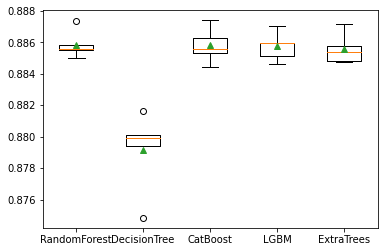

In [17]:
plt.boxplot(models_scores_results, labels=models_names, showmeans=True)
plt.show()

### B. Searching for the best l1 model combination

In [18]:
# I take only TOP5 classifiers (most promising) to check build and check meta (names of classifiers taken from classifiers dictionary)
taken_classifiers = ["RandomForest", "DecisionTree", "CatBoost", "LGBM", "ExtraTrees"]

In [19]:

# This function searches best stacking configuration
def best_stacking_search():
    cls_list = []
    best_auc = -1
    i=0

    best_cls_experiment = list()

    print(">>>> Training started <<<<")

    for cls_comb in range(2, len(taken_classifiers)+1):
        for subset in itertools.combinations(taken_classifiers, cls_comb):
            cls_list.append(subset)

    print(f"Total number of model combination: {len(cls_list)}")


    for cls_exp in cls_list:
        cls_labels = list(cls_exp)

        classifier_exp = []
        for ii in range(len(cls_labels)):
            label = taken_classifiers[ii]
            classifier = classifiers[label]
            classifier_exp.append(classifier)


        sclf = StackingCVClassifier(classifiers = classifier_exp,
                                    shuffle = False,
                                    use_probas = True,
                                    cv = FOLDS,
                                    meta_classifier = mlr,
                                    n_jobs = -1)

        scores = model_selection.cross_val_score(sclf, X_train, y_train, cv = FOLDS, scoring='accuracy')

        if scores.mean() > best_auc:
            best_cls_experiment = list(cls_exp)
        i += 1
        print(f"  {i} - Stacked combination - Acc {cls_exp}: {scores.mean():.5f}")
        
    return best_cls_experiment

In [20]:
%%time

# This step is time consuming - if you want experiment ... try this but ... you wil have to wait
#>>>> Training started <<<<
#Total number of model combination: 26
#  1 - Stacked combination - Acc ('RandomForest', 'DecisionTree'): 0.88758
#  2 - Stacked combination - Acc ('RandomForest', 'CatBoost'): 0.88768
#  3 - Stacked combination - Acc ('RandomForest', 'ExtraTrees'): 0.88759
#  4 - Stacked combination - Acc ('RandomForest', 'LGBM'): 0.88767
#  5 - Stacked combination - Acc ('DecisionTree', 'CatBoost'): 0.88752
#  6 - Stacked combination - Acc ('DecisionTree', 'ExtraTrees'): 0.88763
#  7 - Stacked combination - Acc ('DecisionTree', 'LGBM'): 0.88760
#  8 - Stacked combination - Acc ('CatBoost', 'ExtraTrees'): 0.88758
#  9 - Stacked combination - Acc ('CatBoost', 'LGBM'): 0.88753
#  10 - Stacked combination - Acc ('ExtraTrees', 'LGBM'): 0.88759
#  11 - Stacked combination - Acc ('RandomForest', 'DecisionTree', 'CatBoost'): 0.88767
#  12 - Stacked combination - Acc ('RandomForest', 'DecisionTree', 'ExtraTrees'): 0.88766
#  13 - Stacked combination - Acc ('RandomForest', 'DecisionTree', 'LGBM'): 0.88760
#  14 - Stacked combination - Acc ('RandomForest', 'CatBoost', 'ExtraTrees'): 0.88763
#  15 - Stacked combination - Acc ('RandomForest', 'CatBoost', 'LGBM'): 0.88763
#  16 - Stacked combination - Acc ('RandomForest', 'ExtraTrees', 'LGBM'): 0.88749
#  17 - Stacked combination - Acc ('DecisionTree', 'CatBoost', 'ExtraTrees'): 0.88757
#  18 - Stacked combination - Acc ('DecisionTree', 'CatBoost', 'LGBM'): 0.88766
#  19 - Stacked combination - Acc ('DecisionTree', 'ExtraTrees', 'LGBM'): 0.88753
#  20 - Stacked combination - Acc ('CatBoost', 'ExtraTrees', 'LGBM'): 0.88759
#  21 - Stacked combination - Acc ('RandomForest', 'DecisionTree', 'CatBoost', 'ExtraTrees'): 0.88767
#  22 - Stacked combination - Acc ('RandomForest', 'DecisionTree', 'CatBoost', 'LGBM'): 0.88759
#  23 - Stacked combination - Acc ('RandomForest', 'DecisionTree', 'ExtraTrees', 'LGBM'): 0.88754
#  24 - Stacked combination - Acc ('RandomForest', 'CatBoost', 'ExtraTrees', 'LGBM'): 0.88766
#  25 - Stacked combination - Acc ('DecisionTree', 'CatBoost', 'ExtraTrees', 'LGBM'): 0.88756
#  26 - Stacked combination - Acc ('RandomForest', 'DecisionTree', 'CatBoost', 'ExtraTrees', 'LGBM'): 0.88754

# ------------- CODE ---------------
# SCENARIO 1. Use this line if you want to search for best combination
#best_cls_experiment = best_stacking_search()
#SCENARIO 1

# SCENARIO 2. else use the best found during my experimentation ...
best_cls_experiment = ['RandomForest', 'DecisionTree', 'ExtraTrees', 'LGBM'] 
# SCENARIO 2.

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


### C. Train the BASE meta-model

In [21]:
print(f'The best models configuration: {best_cls_experiment}')

classifier_exp = []
for label in best_cls_experiment:
        classifier = classifiers[label]
        classifier_exp.append(classifier)

The best models configuration: ['RandomForest', 'DecisionTree', 'ExtraTrees', 'LGBM']


In [22]:
# Check (for sure ...) if there is good classifier configuration (I made mistake previously so ... got poor results ...)
classifier_exp

[RandomForestClassifier(max_depth=15, min_samples_leaf=8, random_state=2021),
 DecisionTreeClassifier(max_depth=5),
 ExtraTreesClassifier(criterion='entropy', max_features=0.55, min_samples_leaf=8,
                      min_samples_split=4),
 LGBMClassifier(device='gpu')]

In [23]:
# "Ensemble learning works best when the base models are not correlated. 
# For instance, you can train different models such as linear models, decision trees, and neural nets on different datasets or features. 
# The less correlated the base models, the better." (https://neptune.ai/blog/ensemble-learning-guide)

# ------------- CODE ---------------
# # SCENARIO 1 This is for manual experimentation
#scl = StackingCVClassifier(classifiers= [cl2, cl5, cl6, cl7], #[cl1, cl2, cl3, cl4, cl5, cl6, cl7, cl8, cl9]
#                            meta_classifier = mlr, # use meta-classifier
#                            use_probas = PROBAS,   # use_probas = True/False
#                            random_state = RANDOM_SEED)


# # SCENARIO 2. This line takes best experiment from stacking combination
# I know this is redundand (I could use trained models from provious step) but I make this step for clarity

scl = StackingCVClassifier(classifiers= classifier_exp,
                            meta_classifier = mlr, # use meta-classifier
                            use_probas = PROBAS,   # use_probas = True/False
                            random_state = RANDOM_SEED)

scores = model_selection.cross_val_score(scl, X_train, y_train, cv = FOLDS, scoring='accuracy')
models_scores_results.append(scores)
models_names.append('scl')
print("Meta model (slc) - accuracy: %0.5f " % (scores.mean()))
scl.fit(X_train, y_train)

top_meta_model = scl
base_acc = scores.mean()

Meta model (slc) - accuracy: 0.88557 


### D. Find hyperparameters for meta-model

#### D1. Find keys for tuning

In [24]:
# meta prefix for l2 classifier but feel free to optimize l1 classifier as well
scl.get_params().keys()

dict_keys(['classifiers', 'cv', 'drop_proba_col', 'meta_classifier__C', 'meta_classifier__class_weight', 'meta_classifier__dual', 'meta_classifier__fit_intercept', 'meta_classifier__intercept_scaling', 'meta_classifier__l1_ratio', 'meta_classifier__max_iter', 'meta_classifier__multi_class', 'meta_classifier__n_jobs', 'meta_classifier__penalty', 'meta_classifier__random_state', 'meta_classifier__solver', 'meta_classifier__tol', 'meta_classifier__verbose', 'meta_classifier__warm_start', 'meta_classifier', 'n_jobs', 'pre_dispatch', 'random_state', 'shuffle', 'store_train_meta_features', 'stratify', 'use_clones', 'use_features_in_secondary', 'use_probas', 'verbose', 'randomforestclassifier', 'decisiontreeclassifier', 'extratreesclassifier', 'lgbmclassifier', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'random

#### D2. Find the best parameter (SearchGridCV)
I just wanted to show how to optimize so taken only one C - Inverse of regularization strength.

In [25]:
def meta_best_params_search():

    scl_params = {'meta_classifier__C': [0.001, 0.01, 0.1, 1, 10]}

    print(">>>> Searching for best parameters started <<<<")

    grid = GridSearchCV(estimator=scl, 
                        param_grid= scl_params, 
                        cv=5,
                        refit=True)
    grid.fit(X_train, y_train)

    cv_keys = ('mean_test_score', 'std_test_score', 'params')

    for r, _ in enumerate(grid.cv_results_['mean_test_score']):
        print("%0.3f +/- %0.2f %r" % (grid.cv_results_[cv_keys[0]][r], grid.cv_results_[cv_keys[1]][r] / 2.0, grid.cv_results_[cv_keys[2]][r]))

    print('Best parameters: %s' % grid.best_params_)
    print('Accuracy: %.5f' % grid.best_score_)
    return grid, grid.best_score_

In [26]:
# Run this if you want to search for optimum hyperparameters - in this example I am searching only for meta-model but you can tune other hyperparameters
# but for ['CatBoost', 'ExtraTrees', 'LGBM'] I found C =  was the best
#>>>> Searching for best parameters started <<<<
#0.886 +/- 0.00 {'meta_classifier__C': 0.001}
#0.886 +/- 0.00 {'meta_classifier__C': 0.01}
#0.886 +/- 0.00 {'meta_classifier__C': 0.1}
#0.886 +/- 0.00 {'meta_classifier__C': 1}
#0.886 +/- 0.00 {'meta_classifier__C': 10}
#Best parameters: {'meta_classifier__C': 0.1}

# ------------- CODE ---------------
#hyper_meta_model, hyper_acc = meta_best_params_search()

### E. Take the BEST (optimized) meta-classifier

In [27]:
#. SCENARIO 1. Use this if you were looking for best params (D2 section) - previous section
#if hyper_acc > base_acc:
#    top_meta_model = hyper_meta_model
#. SCENARIO 1.
    
    
# SCENARIO 2. or this if you want to avoid searching for hyperparameters and use the best one found during my research
# for 
# a. ['CatBoost', 'ExtraTrees', 'LGBM'] C = 1
# b. but sometimes .... default parameters are better :) You have to conduct experiments ... :)
scl = StackingCVClassifier(classifiers= classifier_exp,
                            meta_classifier = LogisticRegression(C = 0.1), # use meta-classifier
                            use_probas = PROBAS,   # use_probas = True/False
                            random_state = RANDOM_SEED)

scores = model_selection.cross_val_score(scl, X_train, y_train, cv = FOLDS, scoring='accuracy')
print("Meta model (slc) - accuracy: %0.5f " % (scores.mean()))
scl.fit(X_train, y_train)
top_meta_model = scl
# SCENARIO 2.

classifiers["scl"] = top_meta_model

Meta model (slc) - accuracy: 0.88554 


# 8. Evaluate models (AUC)

In [28]:
# Let's see how the models work ... We will operate on probas ...

preds = pd.DataFrame()

for key in classifiers:
    y_pred = classifiers[key].predict_proba(X_test)[:,1]
    preds[f"{key}"] = y_pred
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f"{key} -> AUC: {auc:.5f}")

preds[TARGET] = pd.DataFrame(y_test).reset_index(drop=True)

# Tested during experiments --- (all classifiers)
#KNN -> AUC: 0.68637
#RandomForest -> AUC: 0.93863
#GaussianNB -> AUC: 0.87196
#DecisionTree -> AUC: 0.92070
#CatBoost -> AUC: 0.93794
#LGBM -> AUC: 0.93917
#ExtraTrees -> AUC: 0.93890
#MLP -> AUC: 0.91257
#scl -> AUC: 0.93899

RandomForest -> AUC: 0.93407
DecisionTree -> AUC: 0.92046
CatBoost -> AUC: 0.93405
LGBM -> AUC: 0.93431
ExtraTrees -> AUC: 0.93361
scl -> AUC: 0.93448


In [29]:
# Pandas ... show me preds and model probas please ...

preds.head(10)

,RandomForest,DecisionTree,CatBoost,LGBM,ExtraTrees,scl,Survived
0,0.799489,0.784856,0.810199,0.815904,0.754060,0.833032,1
1,0.854431,0.918088,0.891787,0.898901,0.884842,0.891570,1
2,0.906494,0.918088,0.930040,0.917533,0.920525,0.914270,1
3,0.009407,0.028983,0.008582,0.013013,0.003558,0.043726,0
4,0.258297,0.209117,0.308362,0.184600,0.177523,0.133438,1
5,0.131955,0.209117,0.142373,0.129718,0.141357,0.086822,1
6,0.006212,0.032131,0.005478,0.002623,0.003514,0.042505,0
7,0.930073,0.918088,0.942727,0.924068,0.928747,0.919863,1
8,0.221185,0.209117,0.236275,0.216551,0.252140,0.152672,0
9,0.629961,0.791153,0.622201,0.596803,0.635261,0.608227,0


# 9. Understand models

## 9A. Plot prediction distribution

In [30]:
# Seaborn will now show us how the models predict survival ...

def plot_model_AUC(cls_models):
    NUM_CLASS = len(cls_models)
    sns.set(font_scale = 1)
    sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
                   "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
                   'ytick.color': '0.4'})

    f, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols = NUM_CLASS)

    for key, counter in zip(cls_models, range(NUM_CLASS)):

        y_pred = preds[key]

        auc = metrics.roc_auc_score(y_test, y_pred)
        textstr = f"AUC: {auc:.3f}"


        false_pred = preds[preds[TARGET] == 0]
        sns.distplot(false_pred[key], hist=True, kde=True, 
                     bins=int(50), color = 'red', 
                     hist_kws={'edgecolor':'black'}, ax = ax[counter])


        true_pred = preds[preds[TARGET] == 1]
        sns.distplot(true_pred[key], hist=True, kde=True, 
                     bins=int(50), color = 'green', 
                     hist_kws={'edgecolor':'black'}, ax = ax[counter])


        props = dict(boxstyle='round', facecolor='white', alpha=0.5)

        ax[counter].text(0.05, 0.95, textstr, transform=ax[counter].transAxes, fontsize=14,
                        verticalalignment = "top", bbox=props)

        ax[counter].set_title(f"{key}")
        ax[counter].set_xlim(0,1)
        ax[counter].set_xlabel("Probability")

    plt.tight_layout()

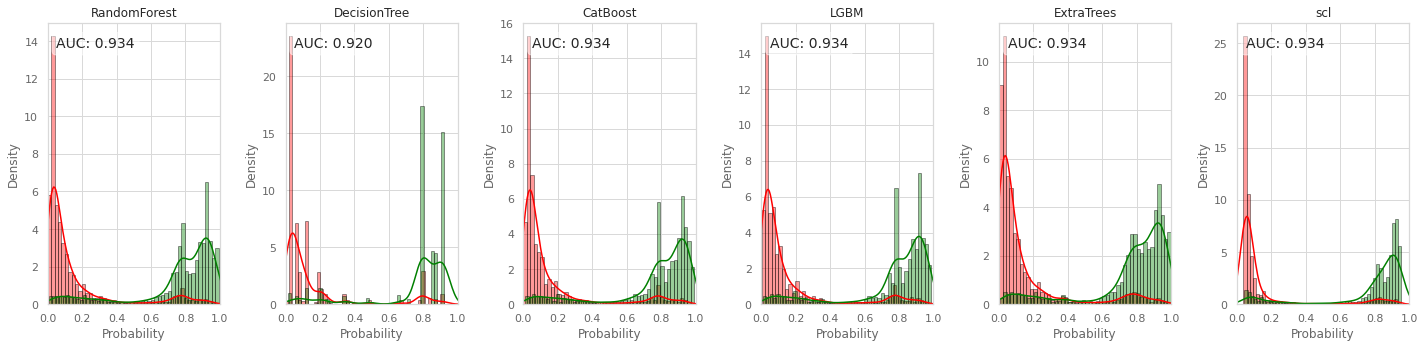

In [31]:
plot_model_AUC(classifiers)

## 9B. Plot model explanatory (using Shap)

In [32]:
shap.initjs()

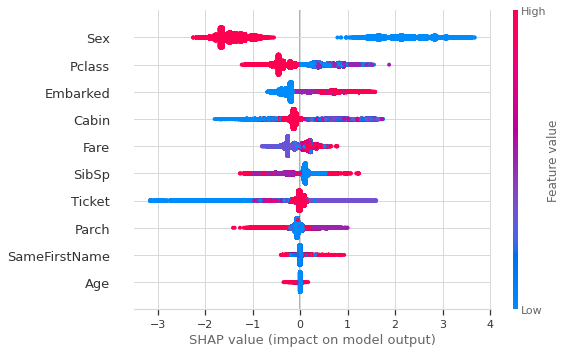

In [33]:
# Lets explain how the models see the competition world ... What features are important .... What values drive the model for survival ...
# I made it only for one fast model (LGBM). Feel free to understand other models ...


explainer = shap.TreeExplainer(classifiers["LGBM"])
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train)

# 10. Final prediction (ensemble-learning with meta-classifier)

In [34]:
# And we approaching to the final stage ... prediction ... 

test_preds = classifiers['scl'].predict_proba(test)[:,1]

In [35]:
# Grandmaster tip -> Alexander Ryzhkov
# They way of finding "the best" from "the best" :) that is, secret codes for the game ...

threshold = pd.Series(test_preds).sort_values(ascending = False).head(34911).values[-1]
print(f"Current threshold is: {threshold}")

Current threshold is: 0.26956707322582496


In [36]:
# threshold from previous section was too hard for me so I decided to check only and use more reasonable value
#threshold = 0.40
submission['submit_1'] = (test_preds > threshold).astype(int)
submission['submit_1'].mean()

0.3491

# 11. Ensemble prediction
This is only for competition purpose (to boost score). 

In [37]:
# Next Grandmaster tip -> BIZEN
# Hacking the system :) How about mixing it with another submissions

submission['submit_2'] = pd.read_csv("../input/tps04preds/dae.csv")[TARGET]
submission['submit_3'] = pseudo_labels[TARGET]

In [38]:
submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis = 1).value_counts()

0    64415
3    34132
1     1240
2      213
dtype: int64

In [39]:
submission[TARGET] = (submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis=1) >= 2).astype(int)
submission[TARGET].mean()

0.34345

# 12. Submit prediction

In [40]:
# and now .... hold your breath and upload the results on the server and wait for the results ... TOP? How much?

submission[['PassengerId', TARGET]].to_csv("REMEK-TPS04-FINAL005.csv", index = False)

# 13. What's next? Todo's
- [x] Stacking different combinations of classifiers (GridSearchCV)
- [x] Hyperparameters tuning for L1 models (Optuna / GridSearchCV)
- [x] Models understanding (Shap)
- [x] Hyperparameters for meta-model ()
- [x] Hacking the system :)

## If you like it - **please vote**. This is my first notebook published on Kaggle. I really appreciate any feedback and proposal for improvements, suggestions.